In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.plotting import scatter_matrix
from sklearn import metrics
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SMOTENC, SVMSMOTE, KMeansSMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from data_processing import (identify_merger, clean_hcris_before_2010, clean_hcris_after_2010, imputation_method, resampling)
from grid_search import (grid_search_lr, grid_search_lda, grid_search_knn, grid_search_dt, grid_search_rf, grid_search_xgb)

In [2]:
# ignore warnings
warnings.filterwarnings("ignore")
# Set the display options
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
pd.options.mode.use_inf_as_na = True

# Data preparation

Firstly, I upload the verified data from Lina and identify the potential mergers (details see identify_merger() in data_processing.py).\
Return the data after identification as a dataframe (df1).\
Drop the 'Year of change' after 2012.

In [3]:
verified_data = identify_merger()
verified_data.drop(verified_data[verified_data['Year of change']==2017].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2016].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2015].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2014].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2013].index,inplace=True)

         id  Type of closure  \
0     10009              1.0   
1     10010              5.0   
2     10015              1.0   
3     10025              4.0   
4     10027              1.0   
..      ...              ...   
365  670018              1.0   
366  670021              4.0   
367  670029              5.0   
368  670052              4.0   
369  670066              4.0   

    Type of change (Convert/close/merge/change names)  Year of change  merged  
0                                               Close          2012.0       0  
1                                                Open             NaN       0  
2                                               Close          2011.0       0  
3                                         Open/merger          2013.0       1  
4                                               Close          2013.0       0  
..                                                ...             ...     ...  
365      Close, reopen in 2015 but probably partially  

Secondly, upload the unmatched hospital-level data obtained from Lina as another dataframe (df2).\
Drop the 'Year of change' after 2012.

In [4]:
hosp_data = pd.read_csv('hosp_closest_info_v5.csv', index_col=0, thousands=',')
print(f"The shape of original HCRIS 2012:{hosp_data.shape}")
# Match the column names with df1
hosp_data.rename(columns={'provider': 'id'}, inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2017].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2016].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2015].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2014].index,inplace=True)
hosp_data.drop(hosp_data[hosp_data['year']==2013].index,inplace=True)

The shape of original HCRIS 2012:(103148, 123)


Merge two dataframes by hospital ids.

In [5]:
verified_hosp_data = pd.merge(verified_data, hosp_data, how='outer')
# Fill the value of column 'merged' in hosp_data not included in verified_data with 0
verified_hosp_data = verified_hosp_data.fillna({'merged':0})

# Data cleaning

Drop duplicates and keep the latest date information.

In [6]:
# Return DataFrame with duplicate rows removed except for the id with the recent date.
verified_hosp_data.drop_duplicates(subset=['id'], keep='last', inplace=True)
verified_hosp_data.sort_values(by='id', ascending=True, inplace = True)
verified_hosp_data.reset_index(drop=True, inplace = True)
print(verified_hosp_data.shape)
verified_hosp_data.head(20)

(7979, 127)


,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,hrrnum,year,ssacounty,fips,zip_short.x,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,Hospital.Type,Hospital.Ownership,ehr,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,race.x,race.y,buyin_mo,type_adm.x,type_adm.y,type_adm,ownership,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,ind_close,state_cd,id_closed,zip_short.y,year_close_combined,dist,ind_nearest,ind_after_1,ind_after_2,ind_after_3,ind_after_4,ind_after_5,ind_after_6,ind_after_7,ind_after_8,rate,hmo_rate,hhi
0,10001,NaN,NaN,NaN,0.0,2.0,2012,1340.0,1069.0,36301,10001,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Amended,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,NaN,NaN,NaN,8633626.0,NaN,NaN,0.1498,NaN,NaN,408.0,149328.0,42785.0,15986.0,87760,NaN,2160.600098,NaN,7790.0,3931.0,17435,NaN,NaN,NaN,NaN,NaN,215.0,NaN,70,83,74,54,61,69,67,63,83,75,300 or more,33,Acute Care Hospitals,Government - Hospital District or Authority,1.0,3.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,2.000000,78.572954,0.454330,0.838671,0.158956,0.289442,0.654804,0.027284,0.317912,Public,1,0,42.732843,0.589310,1026.0,3009.226320,744.890000,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,0,AL,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,744.890000,744.890000,3009.226320
1,10004,NaN,NaN,NaN,0.0,373.0,2001,1350.0,1071.0,35740,10004,10/1/2000,01-OCT-00,8/31/2001,31-AUG-01,Settled,NORTH JACKSON HOSPITAL,47065 ALABAMA HWAY 277,88,BRIDGEPORT,AL,35740,NaN,NaN,NaN,NaN,25944.0,NaN,NaN,NaN,NaN,NaN,49.0,16415.0,1277.0,NaN,2195,NaN,93.660000,NaN,372.0,92.0,763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,15.571430,0.122729,1014.0,1924.922000,NaN,6.0,53291.0,8.7,19.9,82.595560,0.000544,0.000544,0.001070,0.000000,0.000094,0.000019,0.000019,0.0,0.092229,0.092229,0.001726,0.001726,0.351316,0.351316,0.166388,0,AL,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,1924.922000
2,10005,NaN,NaN,NaN,0.0,NaN,2005,NaN,NaN,35657,10005,10/1/2004,01-OCT-04,9/30/2005,30-SEP-05,Reopened,MARSHALL MEDICAL CENTER-SOUTH,HIGHWAY 431,NaN,BOAZ,AL,35657,MARSHALL,NaN,NaN,NaN,1724745.0,NaN,NaN,NaN,NaN,NaN,108.0,39420.0,14303.0,NaN,24961,NaN,568.790000,NaN,2716.0,842.0,6482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Acute Care Hospitals,Government - Hospital District or Authority,1.0,2.666667,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Public,1,0,60.018520,0.633207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,AL,10143.0,35055.0,2009.0,32.270870,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
3,10006,NaN,NaN,NaN,0.0,1.0,2012,1380.0,1077.0,35630,10006,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Reopened,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,818,FLORENCE,AL,35630,LAUDERDALE,NaN,NaN,N

Upload the combined data for verified and HCRIS.

In [7]:
verified_hcris_data_2012 = pd.read_csv('verified_hcris_data_2012.csv')
verified_hcris_data_2012 = verified_hcris_data_2012.loc[:,['id']]
verified_hcris_data_2012.head(20)

,id
0,10001
1,10005
2,10006
3,10007
4,10008
5,10009
6,10010
7,10011
8,10012
9,10015


Match our data2 with data1 by hospital ids.

In [8]:
hosp_hcris = pd.merge(verified_hosp_data, verified_hcris_data_2012)
hosp_hcris.head(20)

,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,hrrnum,year,ssacounty,fips,zip_short.x,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,Hospital.Type,Hospital.Ownership,ehr,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,race.x,race.y,buyin_mo,type_adm.x,type_adm.y,type_adm,ownership,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,ind_close,state_cd,id_closed,zip_short.y,year_close_combined,dist,ind_nearest,ind_after_1,ind_after_2,ind_after_3,ind_after_4,ind_after_5,ind_after_6,ind_after_7,ind_after_8,rate,hmo_rate,hhi
0,10001,NaN,NaN,NaN,0.0,2.0,2012,1340.0,1069.0,36301,10001,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Amended,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,NaN,NaN,NaN,8633626.0,NaN,NaN,0.1498,NaN,NaN,408.0,149328.0,42785.0,15986.0,87760,NaN,2160.600098,NaN,7790.0,3931.0,17435,NaN,NaN,NaN,NaN,NaN,215.0,NaN,70,83,74,54,61,69,67,63,83,75,300 or more,33,Acute Care Hospitals,Government - Hospital District or Authority,1.0,3.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,2.000000,78.572954,0.454330,0.838671,0.158956,0.289442,0.654804,0.027284,0.317912,Public,1,0,42.732843,0.589310,1026.0,3009.226320,744.890000,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,0,AL,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,744.890000,744.890000,3009.226320
1,10005,NaN,NaN,NaN,0.0,NaN,2005,NaN,NaN,35657,10005,10/1/2004,01-OCT-04,9/30/2005,30-SEP-05,Reopened,MARSHALL MEDICAL CENTER-SOUTH,HIGHWAY 431,NaN,BOAZ,AL,35657,MARSHALL,NaN,NaN,NaN,1724745.0,NaN,NaN,NaN,NaN,NaN,108.0,39420.0,14303.0,NaN,24961,NaN,568.790000,NaN,2716.0,842.0,6482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Acute Care Hospitals,Government - Hospital District or Authority,1.0,2.666667,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Public,1,0,60.018520,0.633207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,AL,10143.0,35055.0,2009.0,32.270870,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,10006,NaN,NaN,NaN,0.0,1.0,2012,1380.0,1077.0,35630,10006,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Reopened,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,818,FLORENCE,AL,35630,LAUDERDALE,NaN,NaN,NaN,3498027.0,NaN,NaN,0.0951,NaN,NaN,358.0,130670.0,28599.0,7909.0,52665,NaN,968.530029,NaN,5039.0,1765.0,10862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,84,76,57,61,67,64,60,78,57,300 or more,30,Acute Care Hospitals,Government - Hospital District or Authority,1.0,2.000000,1.000000,2.000000,1.666667,1.000000,2.000000,3.000000,1.666667,78.830645,0.427419,0.917742,0.079032,0.182258,0.627419,0.372581,0.000000,Public,1,0,30.340782,0.403038,1036.0,550.139739,739.490000,3.0,92781.0,8.3,17.6,81.355019,0.000496,0.000474,0.001918,0.000022,0.000216,0.000011,0.000011,0.0,0.123032,0.123032,0.002996,0.002996,0.551158,0.551158,0.297248,0,AL,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,739.490000,739.490000,550.139739
3,10007,NaN,NaN,

Clean the data by dropping columns with more than 60% of the values are missing.

In [9]:
# Find the columns with nan greater than 60%
for column in hosp_hcris:
    count_nan = hosp_hcris[column].isna().sum()
    nan_pct = count_nan/len(hosp_hcris[column])*100
    print(f"{column} has {round(nan_pct,2)}% nan")
    if nan_pct > 60:
        hosp_hcris = hosp_hcris.drop(column, axis=1)

id has 0.0% nan
Type of closure has 96.95% nan
Type of change (Convert/close/merge/change names) has 96.95% nan
Year of change has 99.46% nan
merged has 0.0% nan
hrrnum has 3.03% nan
year has 0.0% nan
ssacounty has 6.96% nan
fips has 6.37% nan
zip_short.x has 0.0% nan
prvdr_num has 0.0% nan
fyb has 0.0% nan
fybstr has 0.0% nan
fye has 0.0% nan
fyestr has 0.0% nan
status has 0.0% nan
hospital_name has 0.0% nan
street_addr has 0.08% nan
po_box has 84.32% nan
city has 0.0% nan
state has 0.0% nan
zip_code has 0.0% nan
county has 0.39% nan
ime1 has 82.94% nan
ime2 has 99.38% nan
ime3 has 100.0% nan
dsh1 has 53.96% nan
dsh2 has 99.61% nan
dsh3 has 100.0% nan
dshpct has 55.19% nan
gme_part_a has 82.48% nan
gme_part_b has 80.81% nan
beds has 0.02% nan
bed_days has 0.0% nan
medicare_days has 0.66% nan
medicaid_days has 11.78% nan
days has 0.0% nan
intres has 80.58% nan
employees has 0.79% nan
volunteers has 99.0% nan
medicare_disch has 0.69% nan
medicaid_disch has 9.18% nan
discharges has 0.0% 

Convert non-numerical values into numerical values.\
For coulmns mixed with number and strings, first convert them into categorial then into numerical (or directly replace strings with numbers).

In [10]:
hosp_hcris = hosp_hcris.replace("Not Available",np.nan)
hosp_hcris = hosp_hcris.replace("N/A",np.nan)
hosp_hcris['state'] = hosp_hcris['state'].astype(str)
hosp_hcris['Hospital.Type_cat'] = LabelEncoder().fit_transform(hosp_hcris['Hospital.Type'])
hosp_hcris['Hospital.Ownership_cat'] = LabelEncoder().fit_transform(hosp_hcris['Hospital.Ownership'])
hosp_hcris['ownership_cat'] = LabelEncoder().fit_transform(hosp_hcris['ownership'])
hosp_hcris['state_cd_cat'] = LabelEncoder().fit_transform(hosp_hcris['state_cd'])
hosp_hcris['state_cat'] = LabelEncoder().fit_transform(hosp_hcris['state'])
hosp_hcris['status_cat'] = LabelEncoder().fit_transform(hosp_hcris['status'])
hosp_hcris['city_cat'] = LabelEncoder().fit_transform(hosp_hcris['city'])
hosp_hcris['county_cat'] = LabelEncoder().fit_transform(hosp_hcris['county'])
# Drop the non-numerical columns
hosp_hcris = hosp_hcris.drop(['Hospital.Type', 'Hospital.Ownership', 'ownership', 'state', 'city', 'county', 'status', 'state_cd'], axis=1)
# For columns containing inf (most of which are prop) and 'num_complete_survey'
hosp_hcris = hosp_hcris.replace(
    {np.inf: 1, 'FEWER THAN 50': 25, 'Fewer than 100': 50, 'Between 100 and 299': 200, '300 or more': 5000, '300 or More': 5000})
# Convert urban_rural to binary
hosp_hcris['rural_urban_cat'] = hosp_hcris['rural_urban']
for value in hosp_hcris['rural_urban']:
    if value == np.nan:
        continue
    if value > 4:
        hosp_hcris['rural_urban_cat'] = hosp_hcris['rural_urban_cat'].replace(
                value, 0) # greater than 4 - rural
    elif value <= 4:
        hosp_hcris['rural_urban_cat'] = hosp_hcris['rural_urban_cat'].replace(
                value, 1) # else -urban
hosp_hcris['rural_urban_cat'].value_counts()
# Drop the non-numerical columns not considered as input
hosp_hcris = hosp_hcris.drop(["year", "zip_short.x", "prvdr_num", "fyb", "fybstr", "fye",
                                              "fyestr", "zip_code", "hospital_name", "street_addr"], axis=1)
# Make sure all remaining columns are numerical
for column in hosp_hcris:
    hosp_hcris[column] = pd.to_numeric(hosp_hcris[column])
hosp_hcris.head(20)

,id,merged,hrrnum,ssacounty,fips,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,ehr,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,race.x,race.y,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,hsanum,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,ind_close,ind_after_1,ind_after_2,ind_after_3,ind_after_4,ind_after_5,ind_after_6,ind_after_7,ind_after_8,rate,hmo_rate,hhi,Hospital.Type_cat,Hospital.Ownership_cat,ownership_cat,state_cd_cat,state_cat,status_cat,city_cat,county_cat,rural_urban_cat
0,10001,0.0,2.0,1340.0,1069.0,8633626.0,0.1498,408.0,149328.0,42785.0,15986.0,87760,2160.600098,7790.0,3931.0,17435,70,83,74,54,61,69,67,63,83,75,5000,33,1.0,3.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,2.000000,78.572954,0.454330,0.838671,0.158956,0.289442,0.654804,0.027284,0.317912,1,0,42.732843,0.589310,1026.0,3009.226320,744.890000,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,0,0,0,0,0,0,0,0,0,744.890000,744.890000,3009.226320,0,1,2,1,1,0,754,708,1.0
1,10005,0.0,1.0,1.0,1.0,1724745.0,1.0000,108.0,39420.0,14303.0,1.0,24961,568.790000,2716.0,842.0,6482,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2.666667,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,60.018520,0.633207,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,1.000000,1.000000,1.000000,0,1,2,1,1,2,289,943,1.0
2,10006,0.0,1.0,1380.0,1077.0,3498027.0,0.0951,358.0,130670.0,28599.0,7909.0,52665,968.530029,5039.0,1765.0,10862,55,84,76,57,61,67,64,60,78,57,5000,30,1.0,2.000000,1.000000,2.000000,1.666667,1.000000,2.000000,3.000000,1.666667,78.830645,0.427419,0.917742,0.079032,0.182258,0.627419,0.372581,0.000000,1,0,30.340782,0.403038,1036.0,550.139739,739.490000,3.0,92781.0,8.3,17.6,81.355019,0.000496,0.000474,0.001918,0.000022,0.000216,0.000011,0.000011,0.0,0.123032,0.123032,0.002996,0.002996,0.551158,0.551158,0.297248,0,0,0,0,0,0,0,0,0,739.490000,739.490000,550.139739,0,1,2,1,1,2,938,859,1.0
3,10007,0.0,1.0,1.0,1.0,185865.0,0.0533,78.0,28548.0,4122.0,619.0,5867,153.450000,819.0,133.0,1302,60,84,76,63,55,69,66,67,66,58,5000,26,1.0,2.000000,1.666667,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,78.221150,0.375000,0.942308,0.057692,0.442308,0.740385,0.000000,0.259615,1,0,16.692310,0.206077,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,0,0,0,0,0,0,0,0,1.000000,1.000000,1.000000,0,9,0,1,1,3,2070,380,1.0
4,10008,0.0,7.0,1200.0,1041.0,287870.0,0.1713,29.0,10614.0,1764.0,668.0,3240,106.699997,374.0,166.0,744,67,93,76,66,66,66,70,69,76,67,200,26,1.0,3.333333,2.000000,1.000000,2.333333,1.000000,2.000000,3.000000,1.000000,83.275862,0.275862,0.793103,0.206897,0.379310,0.482759,0.000000,0.517241,1,0,25.655172,0.306094,1056.0,1852.171696,761.710000,8.0,13911.0,8.7,20.3,83.322550,0.000216,0.000216,0.000503,0.000000,0.000072,0.000144,0.000072,0.0,0.095823,0.075336,0.005248,0.003522,1.152325,0.697506,0.405147,0,0,0,0,0,0,0,0,0,761.710000,761.710000,1852.171696,0,5,1,1,1,0,1635,391,0.0
5,10009,0.0,1.0,1510.0,1103.0,175131.0,0.0641,130.0,47450.0,2148.0,293.0,3153,108.370003,572.0,104.0,967,1,1,1,1,

Check the remaining columns and decide the input from them.

In [11]:
print(hosp_hcris.shape)
list(hosp_hcris.columns)

(6103, 93)


['id',
 'merged',
 'hrrnum',
 'ssacounty',
 'fips',
 'dsh1',
 'dshpct',
 'beds',
 'bed_days',
 'medicare_days',
 'medicaid_days',
 'days',
 'employees',
 'medicare_disch',
 'medicaid_disch',
 'discharges',
 'overall',
 'doc_communicate',
 'nurse_communicate',
 'help_quick',
 'staff_explain',
 'pain_control',
 'area_quiet',
 'room_clean',
 'discharge_info',
 'recommend',
 'num_complete_survey',
 'survey_response_rate',
 'ehr',
 'rate.x',
 'mortality',
 'safety',
 'readmin',
 'patient_exp',
 'effective',
 'timely',
 'efficient_img',
 'age',
 'sex',
 'race.x',
 'race.y',
 'buyin_mo',
 'type_adm.x',
 'type_adm.y',
 'type_adm',
 'ind_dsh',
 'ind_teaching',
 'efficiency',
 'utilization',
 'hsanum',
 'prop_discharges',
 'rate.y',
 'rural_urban',
 'pop',
 'unemp',
 'poverty',
 'under_65',
 'prop_phy_pcp',
 'prop_md_pcp',
 'prop_pcp',
 'prop_gi',
 'prop_gen_int',
 'prop_hosp',
 'prop_hosp_short',
 'prop_cah',
 'prop_hosp_adm',
 'prop_hosp_adm_short',
 'prop_hosp_bed',
 'prop_hosp_bed_short',
 '

In [12]:
hosp_hcris.drop(['hrrnum', 'ssacounty', 'fips','ehr', 'hsanum', 'race.x', 'race.y', 'ind_close','ind_after_1','ind_after_2','ind_after_3', 
                        'ind_after_4','ind_after_5', 'ind_after_6', 'ind_after_7', 'ind_after_8'], axis=1 ,inplace=True)

# Check the final data after data cleaning.

(6103, 77)
merged
0.0    5987
1.0     116
dtype: int64
Class 1: 1.9007045715222022%


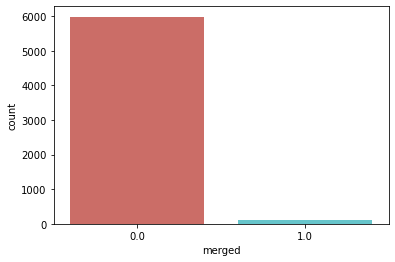

,id,merged,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,overall,doc_communicate,nurse_communicate,help_quick,staff_explain,pain_control,area_quiet,room_clean,discharge_info,recommend,num_complete_survey,survey_response_rate,rate.x,mortality,safety,readmin,patient_exp,effective,timely,efficient_img,age,sex,buyin_mo,type_adm.x,type_adm.y,type_adm,ind_dsh,ind_teaching,efficiency,utilization,prop_discharges,rate.y,rural_urban,pop,unemp,poverty,under_65,prop_phy_pcp,prop_md_pcp,prop_pcp,prop_gi,prop_gen_int,prop_hosp,prop_hosp_short,prop_cah,prop_hosp_adm,prop_hosp_adm_short,prop_hosp_bed,prop_hosp_bed_short,prop_days_inp,prop_days_inp_short,prop_days_inp_med,rate,hmo_rate,hhi,Hospital.Type_cat,Hospital.Ownership_cat,ownership_cat,state_cd_cat,state_cat,status_cat,city_cat,county_cat,rural_urban_cat
0,10001,0.0,8633626.0,0.1498,408.0,149328.0,42785.0,15986.0,87760,2160.600098,7790.0,3931.0,17435,70,83,74,54,61,69,67,63,83,75,5000,33,3.000000,2.000000,3.000000,1.666667,1.000000,2.000000,2.000000,2.000000,78.572954,0.454330,0.289442,0.654804,0.027284,0.317912,1,0,42.732843,0.589310,3009.226320,744.890000,3.0,102369.0,8.1,17.9,84.043998,0.000762,0.000723,0.003829,0.000068,0.000342,0.000049,0.000020,0.0,0.318573,0.298743,0.007356,0.006398,1.704217,1.412049,0.753724,744.890000,744.890000,3009.226320,0,1,2,1,1,0,754,708,1.0
1,10005,0.0,1724745.0,1.0000,108.0,39420.0,14303.0,1.0,24961,568.790000,2716.0,842.0,6482,1,1,1,1,1,1,1,1,1,1,1,1,2.666667,1.000000,2.000000,3.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,0,60.018520,0.633207,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,1,2,1,1,2,289,943,1.0
2,10006,0.0,3498027.0,0.0951,358.0,130670.0,28599.0,7909.0,52665,968.530029,5039.0,1765.0,10862,55,84,76,57,61,67,64,60,78,57,5000,30,2.000000,1.000000,2.000000,1.666667,1.000000,2.000000,3.000000,1.666667,78.830645,0.427419,0.182258,0.627419,0.372581,0.000000,1,0,30.340782,0.403038,550.139739,739.490000,3.0,92781.0,8.3,17.6,81.355019,0.000496,0.000474,0.001918,0.000022,0.000216,0.000011,0.000011,0.0,0.123032,0.123032,0.002996,0.002996,0.551158,0.551158,0.297248,739.490000,739.490000,550.139739,0,1,2,1,1,2,938,859,1.0
3,10007,0.0,185865.0,0.0533,78.0,28548.0,4122.0,619.0,5867,153.450000,819.0,133.0,1302,60,84,76,63,55,69,66,67,66,58,5000,26,2.000000,1.666667,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,78.221150,0.375000,0.442308,0.740385,0.000000,0.259615,1,0,16.692310,0.206077,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,9,0,1,1,3,2070,380,1.0
4,10008,0.0,287870.0,0.1713,29.0,10614.0,1764.0,668.0,3240,106.699997,374.0,166.0,744,67,93,76,66,66,66,70,69,76,67,200,26,3.333333,2.000000,1.000000,2.333333,1.000000,2.000000,3.000000,1.000000,83.275862,0.275862,0.379310,0.482759,0.000000,0.517241,1,0,25.655172,0.306094,1852.171696,761.710000,8.0,13911.0,8.7,20.3,83.322550,0.000216,0.000216,0.000503,0.000000,0.000072,0.000144,0.000072,0.0,0.095823,0.075336,0.005248,0.003522,1.152325,0.697506,0.405147,761.710000,761.710000,1852.171696,0,5,1,1,1,0,1635,391,0.0
5,10009,0.0,175131.0,0.0641,130.0,47450.0,2148.0,293.0,3153,108.370003,572.0,104.0,967,1,1,1,1,1,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,81.647887,0.352113,0.394366,0.957746,0.000000,0.042254,1,0,7.438462,0.066449,544.804729,763.070007,3.0,119953.0,8.7,14.1,84.014572,0.000567,0.000534,0.001734,0.000033,0.000217,0.000033,0.000025,0.0,0.105491,0.101890,0.003776,0.003160,0.641718,0.443540,0.286687,763.070007,763.070007,544.804729,3,10,3,1,1,2,1190,1027,1.0
6,10010,0.0,1112826.0,0.0887,90.0,32850.0,10194.0,2185.0,18949,477.60

In [13]:
print(hosp_hcris.shape)
print(hosp_hcris.groupby('merged').size())
print(f"Class 1: {116/6103*100}%")
sn.countplot(x='merged', data=hosp_hcris, palette='hls')
plt.show()
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
hosp_hcris.head(20)

Copy the data for feature importance.

In [67]:
hosp_hcris_=hosp_hcris.drop(['id','merged'], axis=1)

# ML prediction

Select predictors X and outcome variable y

In [14]:
X, y = hosp_hcris.iloc[:,2:77], hosp_hcris.iloc[:, 1]
# Split the dataset randomly into training dataset (70%) and test dataset (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

Imputate missing values

In [15]:
# Mean imputation
X_train, imp = imputation_method('mean', X_train)
X_test, imp = imputation_method('mean', X_test)
# # Median imputation
# X_train, imp = imputation_method('median', X_train)
# X_test, imp = imputation_method('median', X_test)
# # KNN imputation
# X_train, imp = imputation_method('knn', X_train)
# X_test, imp = imputation_method('knn', X_test)
# # # Multivariate imputation
# X_train, imp = imputation_method('multivariate', X_train)
# X_test, imp = imputation_method('multivariate', X_test)

Resampling methods

In [16]:
BorderlineSMOTE = BorderlineSMOTE(random_state=42,kind="borderline-1")
SMOTE = SMOTE(sampling_strategy=0.3)
SVMSMOTE = SVMSMOTE()
ADASYN = ADASYN()

Tune hyparameters for each model using Gridsearch to find the best hyparameters with highest f1 score.\
For each model, follow the order of original, regular SMOTE, Borderline SMOTE, SVM SMOTE,ADASYN and SMOTE+RUS.

# Logistic Regression (LR)

In [63]:
f1_train_lr_0, f1_lr_0, auprc_lr_0, conf_matrix_lr_0, gridsearch_lr_0 =  grid_search_lr(None, X_test, y_test, X_train, y_train)

Best: 0.550714 using {'C': 10, 'penalty': 'l1'}
The f1 score for the testing data: 0.576271186440678


In [18]:
f1_train_lr_1, f1_lr_1, auprc_lr_1, conf_matrix_lr_1, gridsearch_lr_1 =  grid_search_lr(SMOTE, X_test, y_test, X_train, y_train)

Best: 0.543608 using {'classifier__C': 200, 'classifier__penalty': 'l1'}
The f1 score for the testing data: 0.5416666666666667


In [19]:
f1_train_lr_2, f1_lr_2, auprc_lr_2, conf_matrix_lr_2, gridsearch_lr_2 =  grid_search_lr(BorderlineSMOTE, X_test, y_test, X_train, y_train)

Best: 0.516957 using {'classifier__C': 200, 'classifier__penalty': 'l1'}
The f1 score for the testing data: 0.5054945054945055


In [20]:
f1_train_lr_3, f1_lr_3, auprc_lr_3, conf_matrix_lr_3, gridsearch_lr_3 =  grid_search_lr(SVMSMOTE, X_test, y_test, X_train, y_train)

Best: 0.543165 using {'classifier__C': 500, 'classifier__penalty': 'l1'}
The f1 score for the testing data: 0.5


In [21]:
f1_train_lr_4, f1_lr_4, auprc_lr_4, conf_matrix_lr_4, gridsearch_lr_4 =  grid_search_lr(ADASYN, X_test, y_test, X_train, y_train)

Best: 0.528187 using {'classifier__C': 1000, 'classifier__penalty': 'l1'}
The f1 score for the testing data: 0.48598130841121495


In [22]:
lr = LogisticRegression(solver='liblinear')
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', lr]])
param_grid = {'classifier__C': [
        0.1, 1, 10, 100, 200, 500, 1000], 'classifier__penalty': ['l1', 'l2']}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_lr_5 = gridsearch.best_score_
f1_lr_5= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_lr_5}')

CV Best: 0.537219 using {'classifier__C': 100, 'classifier__penalty': 'l1'}
Test score: 0.5473684210526315


# LDA

In [23]:
f1_train_lda_0, f1_lda_0, auprc_lda_0, conf_matrix_lda_0, gridsearch_lda_0 =  grid_search_lda(None, X_test, y_test, X_train, y_train)

Best: 0.532528 using {'solver': 'lsqr', 'tol': 1e-05}
The f1 score for the testing data: 0.4705882352941177


In [24]:
f1_train_lda_1, f1_lda_1, auprc_lda_1, conf_matrix_lda_1, gridsearch_lda_1 =  grid_search_lda(SMOTE, X_test, y_test, X_train, y_train)

Best: 0.549987 using {'classifier__solver': 'svd', 'classifier__tol': 0.0001}
The f1 score for the testing data: 0.46774193548387094


In [25]:
f1_train_lda_2, f1_lda_2, auprc_lda_2, conf_matrix_lda_2, gridsearch_lda_2 =  grid_search_lda(BorderlineSMOTE, X_test, y_test, X_train, y_train)

Best: 0.502892 using {'classifier__solver': 'svd', 'classifier__tol': 0.0001}
The f1 score for the testing data: 0.41726618705035967


In [26]:
f1_train_lda_3, f1_lda_3, auprc_lda_3, conf_matrix_lda_3, gridsearch_lda_3 =  grid_search_lda(SVMSMOTE, X_test, y_test, X_train, y_train)

Best: 0.522596 using {'classifier__solver': 'svd', 'classifier__tol': 0.0001}
The f1 score for the testing data: 0.4390243902439025


In [27]:
f1_train_lda_4, f1_lda_4, auprc_lda_4, conf_matrix_lda_4, gridsearch_lda_4 =  grid_search_lda(ADASYN, X_test, y_test, X_train, y_train)

Best: 0.478962 using {'classifier__solver': 'svd', 'classifier__tol': 0.0003}
The f1 score for the testing data: 0.4084507042253521


In [28]:
lda = LinearDiscriminantAnalysis()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', lda]])
param_grid = {
        'classifier__solver': ['svd', 'lsqr', 'eigen'],
        'classifier__tol': [1e-05, 0.0001, 0.0003]
    }
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_lda_5 = gridsearch.best_score_
f1_lda_5= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_lda_5}')

CV Best: 0.545005 using {'classifier__solver': 'svd', 'classifier__tol': 0.0001}
Test score: 0.4754098360655738


# KNN

In [35]:
f1_train_knn_0, f1_knn_0, auprc_knn_0, conf_matrix_knn_0, gridsearch_knn_0 =  grid_search_knn(None, X_test, y_test, X_train, y_train)

Best: 0.053480 using {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'distance'}
The f1 score for the testing data: 0.0


In [36]:
f1_train_knn_1, f1_knn_1, auprc_knn_1, conf_matrix_knn_1, gridsearch_knn_1 =  grid_search_knn(SMOTE, X_test, y_test, X_train, y_train)

Best: 0.104727 using {'classifier__algorithm': 'kd_tree', 'classifier__leaf_size': 20, 'classifier__n_neighbors': 10, 'classifier__weights': 'distance'}
The f1 score for the testing data: 0.04232804232804233


In [37]:
f1_train_knn_2, f1_knn_2, auprc_knn_2, conf_matrix_knn_2, gridsearch_knn_2 =  grid_search_knn(BorderlineSMOTE, X_test, y_test, X_train, y_train)

Best: 0.096068 using {'classifier__algorithm': 'auto', 'classifier__leaf_size': 2, 'classifier__n_neighbors': 10, 'classifier__weights': 'distance'}
The f1 score for the testing data: 0.04597701149425287


In [38]:
f1_train_knn_3, f1_knn_3, auprc_knn_3, conf_matrix_knn_3, gridsearch_knn_3 =  grid_search_knn(SVMSMOTE, X_test, y_test, X_train, y_train)

Best: 0.118234 using {'classifier__algorithm': 'kd_tree', 'classifier__leaf_size': 20, 'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'}
The f1 score for the testing data: 0.07194244604316546


In [39]:
f1_train_knn_4, f1_knn_4, auprc_knn_4, conf_matrix_knn_4, gridsearch_knn_4 =  grid_search_knn(ADASYN, X_test, y_test, X_train, y_train)

Best: 0.075013 using {'classifier__algorithm': 'kd_tree', 'classifier__leaf_size': 5, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
The f1 score for the testing data: 0.03045685279187817


In [40]:
knn = KNeighborsClassifier()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', knn]])
param_grid = {'classifier__weights': ['uniform', 'distance'], 'classifier__n_neighbors': [
        2, 3, 5, 10], 'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'classifier__leaf_size': [2, 5, 10, 20, 30]}
gridsearch = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_knn_5 = gridsearch.best_score_
f1_knn_5= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_knn_5}')

CV Best: 0.093070 using {'classifier__algorithm': 'ball_tree', 'classifier__leaf_size': 5, 'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'}
Test score: 0.01379310344827586


# Decision Tree

In [41]:
f1_train_dt_0, f1_dt_0, auprc_dt_0, conf_matrix_dt_0, gridsearch_dt_0 =  grid_search_dt(None, X_test, y_test, X_train, y_train)

Best: 0.578411 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'splitter': 'random'}
The f1 score for the testing data: 0.5454545454545454


In [42]:
f1_train_dt_1, f1_dt_1, auprc_dt_1, conf_matrix_dt_1, gridsearch_dt_1 =  grid_search_dt(SMOTE, X_test, y_test, X_train, y_train)

Best: 0.538595 using {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__splitter': 'best'}
The f1 score for the testing data: 0.5609756097560975


In [43]:
f1_train_dt_2, f1_dt_2, auprc_dt_2, conf_matrix_dt_2, gridsearch_dt_2 =  grid_search_dt(BorderlineSMOTE, X_test, y_test, X_train, y_train)

Best: 0.484444 using {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__splitter': 'best'}
The f1 score for the testing data: 0.6071428571428571


In [44]:
f1_train_dt_3, f1_dt_3, auprc_dt_3, conf_matrix_dt_3, gridsearch_dt_3 =  grid_search_dt(SVMSMOTE, X_test, y_test, X_train, y_train)

Best: 0.508984 using {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__splitter': 'random'}
The f1 score for the testing data: 0.611764705882353


In [45]:
f1_train_dt_4, f1_dt_4, auprc_dt_4, conf_matrix_dt_4, gridsearch_dt_4 =  grid_search_dt(ADASYN, X_test, y_test, X_train, y_train)

Best: 0.570348 using {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__splitter': 'best'}
The f1 score for the testing data: 0.5


In [46]:
dt = DecisionTreeClassifier()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', dt]])
param_grid = {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__splitter': ['random', 'best'],
        'classifier__max_depth': [1, 2, 10],
        'classifier__min_samples_leaf': [1, 2, 10]
    }
gridsearch_dt_5 = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch_dt_5.fit(X_train, y_train)
f1_train_dt_5 = gridsearch_dt_5.best_score_
f1_dt_5= gridsearch_dt_5.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch_dt_5.best_score_, gridsearch_dt_5.best_params_))
print(f'Test score: {f1_dt_5}')

CV Best: 0.523916 using {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__splitter': 'best'}
Test score: 0.5625


# Random Forest

In [65]:
f1_train_rf_0, f1_rf_0, auprc_rf_0, conf_matrix_rf_0, gridsearch_rf_0 =  grid_search_rf(None, X_test, y_test, X_train, y_train)

Best: 0.384191 using {'max_depth': 10, 'n_estimators': 10}
The f1 score for the testing data: 0.52


In [48]:
f1_train_rf_1, f1_rf_1, auprc_rf_1, conf_matrix_rf_1, gridsearch_rf_1 =  grid_search_rf(SMOTE, X_test, y_test, X_train, y_train)

Best: 0.579112 using {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
The f1 score for the testing data: 0.5208333333333334


In [49]:
f1_train_rf_2, f1_rf_2, auprc_rf_2, conf_matrix_rf_2, gridsearch_rf_2 =  grid_search_rf(BorderlineSMOTE, X_test, y_test, X_train, y_train)

Best: 0.540631 using {'classifier__max_depth': 5, 'classifier__n_estimators': 1000}
The f1 score for the testing data: 0.5102040816326531


In [50]:
f1_train_rf_3, f1_rf_3, auprc_rf_3, conf_matrix_rf_3, gridsearch_rf_3 =  grid_search_rf(SVMSMOTE, X_test, y_test, X_train, y_train)

Best: 0.554372 using {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
The f1 score for the testing data: 0.5154639175257733


In [51]:
f1_train_rf_4, f1_rf_4, auprc_rf_4, conf_matrix_rf_4, gridsearch_rf_4 =  grid_search_rf(ADASYN, X_test, y_test, X_train, y_train)

Best: 0.574034 using {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
The f1 score for the testing data: 0.5544554455445544


In [52]:
rf = RandomForestClassifier()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', rf]])
param_grid = {
        'classifier__max_depth': [2, 5, 10, 20],
        'classifier__n_estimators': [10, 100, 1000],
    }
gridsearch_rf_5 = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch_rf_5.fit(X_train, y_train)
f1_train_rf_5 = gridsearch_rf_5.best_score_
f1_rf_5 = gridsearch_rf_5.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch_rf_5.best_score_, gridsearch_rf_5.best_params_))
print(f'Test score: {f1_rf_5}')

CV Best: 0.575642 using {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Test score: 0.5416666666666667


# XGBoost

In [53]:
f1_train_xgb_0, f1_xgb_0, auprc_xgb_0, conf_matrix_xgb_0, gridsearch_xgb_0 =  grid_search_xgb(None, X_test, y_test, X_train, y_train)

[04:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:15:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:15:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:20:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:20:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:20:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [54]:
f1_train_xgb_1, f1_xgb_1, auprc_xgb_1, conf_matrix_xgb_1, gridsearch_xgb_1 =  grid_search_xgb(SMOTE, X_test, y_test, X_train, y_train)

[04:23:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:23:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:23:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:23:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:29:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:30:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [55]:
f1_train_xgb_2, f1_xgb_2, auprc_xgb_2, conf_matrix_xgb_2, gridsearch_xgb_2 =  grid_search_xgb(BorderlineSMOTE, X_test, y_test, X_train, y_train)

[04:33:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:33:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:33:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:33:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:44:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:45:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:45:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [56]:
f1_train_xgb_3, f1_xgb_3, auprc_xgb_3, conf_matrix_xgb_3, gridsearch_xgb_3 =  grid_search_xgb(SVMSMOTE, X_test, y_test, X_train, y_train)

[04:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:49:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:49:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:49:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[04:56:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:57:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:58:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [57]:
f1_train_xgb_4, f1_xgb_4, auprc_xgb_4, conf_matrix_xgb_4, gridsearch_xgb_4 =  grid_search_xgb(ADASYN, X_test, y_test, X_train, y_train)

[05:01:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[05:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:12:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:13:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [58]:
xgb = XGBClassifier()
over = SMOTE
under = RandomUnderSampler(sampling_strategy=0.3)
pipeline = Pipeline(steps=[['over', over],
                           ['under', under],
                           ['classifier', xgb]])
param_grid = {'classifier__min_child_weight': [1, 5, 10]}
gridsearch_xgb_5 = GridSearchCV(estimator=pipeline,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch_xgb_5.fit(X_train, y_train)
f1_train_xgb_5 = gridsearch_xgb_5.best_score_
f1_xgb_5= gridsearch_xgb_5.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch_xgb_5.best_score_, gridsearch_xgb_5.best_params_))
print(f'Test score: {f1_xgb_5}')

[05:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:18:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[05:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

# Evaluation and comparison

The test performance (f1):

In [62]:
test_models = pd.DataFrame({
    'Model': ['Logistic Regression (LR)', 'Linear Discriminant Analysis (LDA)',
              'Random Forest (RF)', 'Decision Tree (DT)', 'XGBoost (XGB)', 'K-Nearest Neighbor (KNN)'],
    'Original': [f1_lr_0, f1_lda_0,
                 f1_rf_0, f1_dt_0, f1_xgb_0,
                 f1_knn_0],
    'SMOTE': [f1_lr_1, f1_lda_1,
              f1_rf_1, f1_dt_1, f1_xgb_1,
              f1_knn_1],
    'Borderline SMOTE': [f1_lr_2, f1_lda_2,
                         f1_rf_2, f1_dt_2, f1_xgb_2,
                         f1_knn_2],
    'SVM SMOTE': [f1_lr_3, f1_lda_3,
                  f1_rf_3, f1_dt_3, f1_xgb_3,
                  f1_knn_3],
    'ADASYN': [f1_lr_4, f1_lda_4,
               f1_rf_4, f1_dt_4, f1_xgb_4,
               f1_knn_4],
    'SMOTE+RUS': [f1_lr_5, f1_lda_5,
                  f1_rf_5, f1_dt_5, f1_xgb_5,
                  f1_knn_5]
})
test_models.sort_values(by='Original', ascending=False)

,Model,Original,SMOTE,Borderline SMOTE,SVM SMOTE,ADASYN,SMOTE+RUS
4,XGBoost (XGB),0.641509,0.628571,0.666667,0.631579,0.580645,0.630137
0,Logistic Regression (LR),0.600000,0.541667,0.505495,0.500000,0.485981,0.547368
3,Decision Tree (DT),0.545455,0.560976,0.607143,0.611765,0.500000,0.562500
2,Random Forest (RF),0.533333,0.520833,0.510204,0.515464,0.554455,0.541667
1,Linear Discriminant Analysis (LDA),0.470588,0.467742,0.417266,0.439024,0.408451,0.475410
5,K-Nearest Neighbor (KNN),0.000000,0.042328,0.045977,0.071942,0.030457,0.013793


We can see that  RF, DT and XGBoost performed the best.

# Feature importance

# Decision Tree

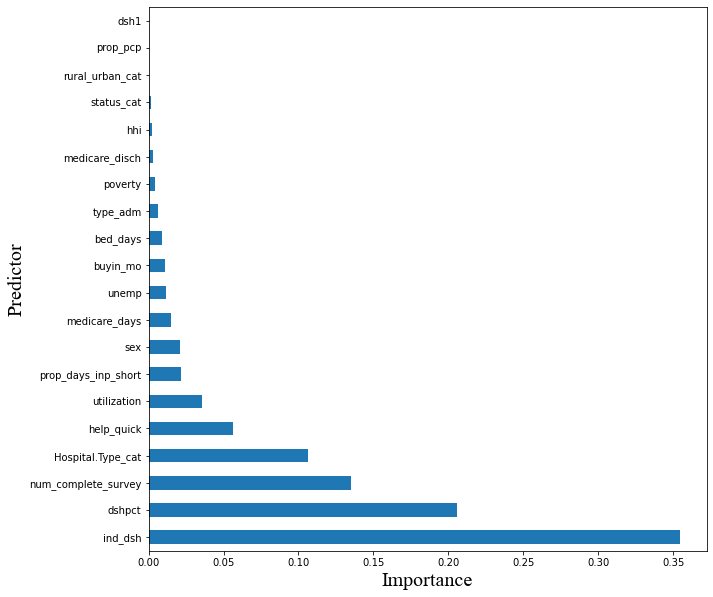

In [69]:
feature_importances_dt_0 = gridsearch_dt_0.best_estimator_.feature_importances_
feat_importances = pd.Series(feature_importances_dt_0, index=hosp_hcris_.columns)
plt.rcParams['figure.figsize'] = [10,10]
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}
plt.xlabel('Importance', font)
plt.ylabel('Predictor', font)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig(r'C:/Users/owofangwei/Desktop/project/py/plots/feature_importance_dt_0.png', bbox_inches = 'tight')

# XGBoost

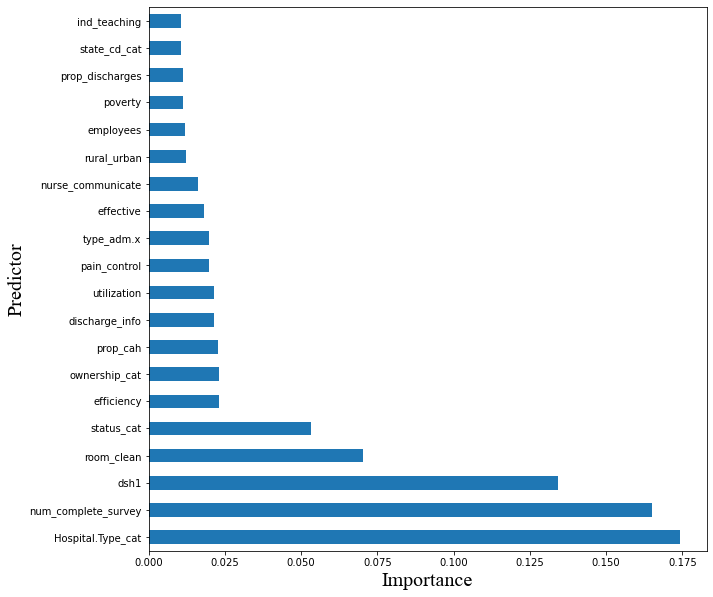

In [70]:
feature_importances_xgb_0 = gridsearch_xgb_0.best_estimator_.feature_importances_
feat_importances = pd.Series(feature_importances_xgb_0, index=hosp_hcris_.columns)
plt.rcParams['figure.figsize'] = [10,10]
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}
plt.xlabel('Importance', font)
plt.ylabel('Predictor', font)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig(r'C:/Users/owofangwei/Desktop/project/py/plots/feature_importance_xgb_0.png', bbox_inches = 'tight')

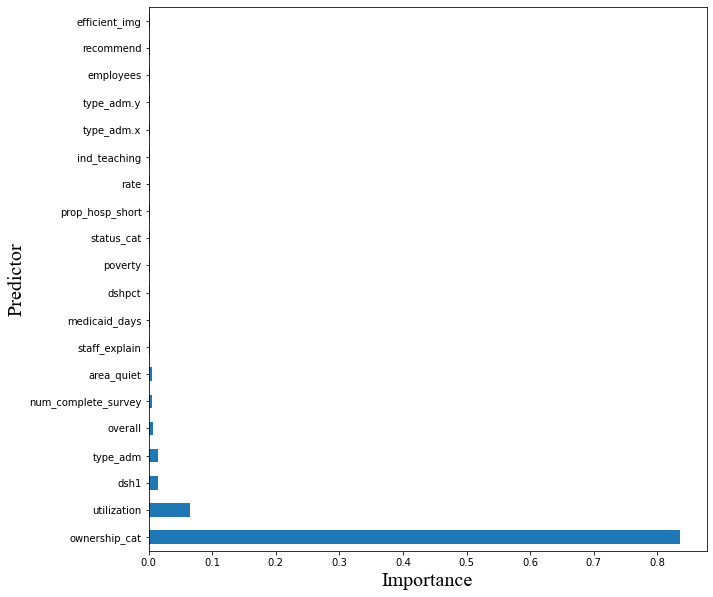

In [71]:
feature_importances_xgb_2 = gridsearch_xgb_2.best_estimator_.named_steps["classifier"].feature_importances_
feat_importances = pd.Series(feature_importances_xgb_2, index=hosp_hcris_.columns)
plt.rcParams['figure.figsize'] = [10,10]
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}
plt.xlabel('Importance', font)
plt.ylabel('Predictor', font)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig(r'C:/Users/owofangwei/Desktop/project/py/plots/feature_importance_xgb_borderline.png', bbox_inches = 'tight')

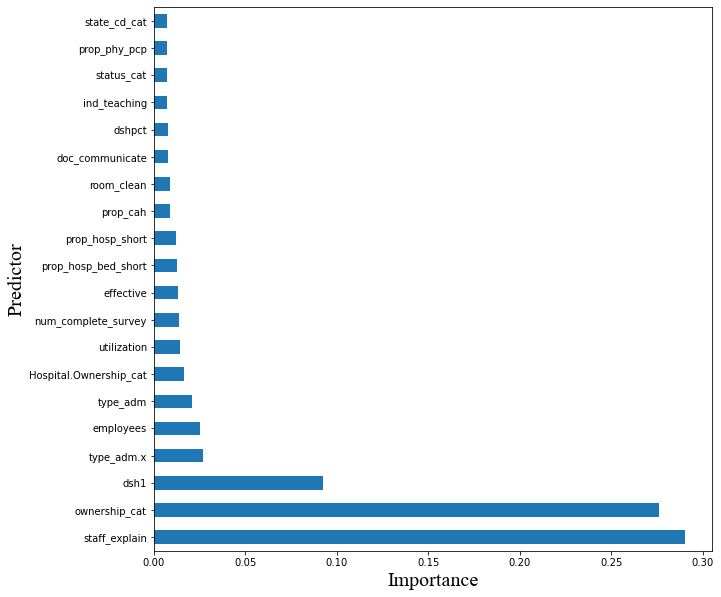

In [72]:
feature_importances_xgb_5 = gridsearch_xgb_5.best_estimator_.named_steps["classifier"].feature_importances_
feat_importances = pd.Series(feature_importances_xgb_5, index=hosp_hcris_.columns)
plt.rcParams['figure.figsize'] = [10,10]
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}
plt.xlabel('Importance', font)
plt.ylabel('Predictor', font)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig(r'C:/Users/owofangwei/Desktop/project/py/plots/feature_importance_xgb_smote_rus.png', bbox_inches = 'tight')

# Random Forest

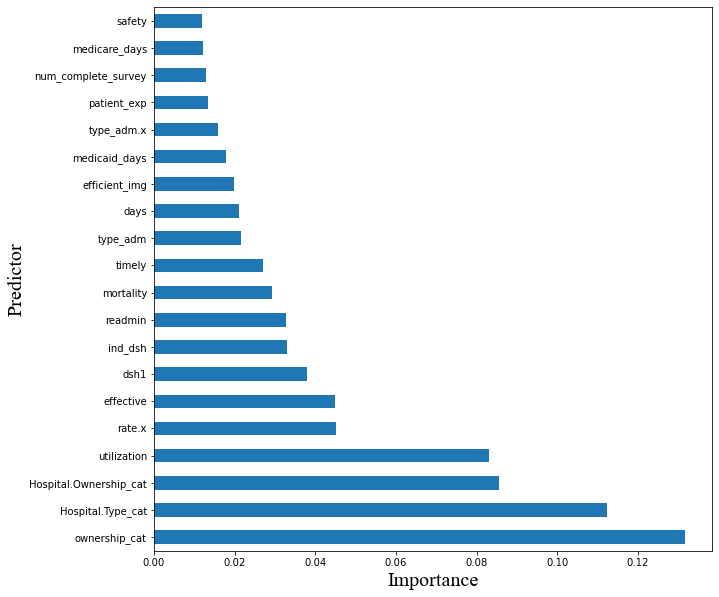

In [73]:
feature_importances_rf_2 = gridsearch_rf_2.best_estimator_.named_steps["classifier"].feature_importances_
feat_importances = pd.Series(feature_importances_rf_2, index=hosp_hcris_.columns)
plt.rcParams['figure.figsize'] = [10,10]
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}
plt.xlabel('Importance', font)
plt.ylabel('Predictor', font)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig(r'C:/Users/owofangwei/Desktop/project/py/plots/feature_importance_rf_borderline.png', bbox_inches = 'tight')

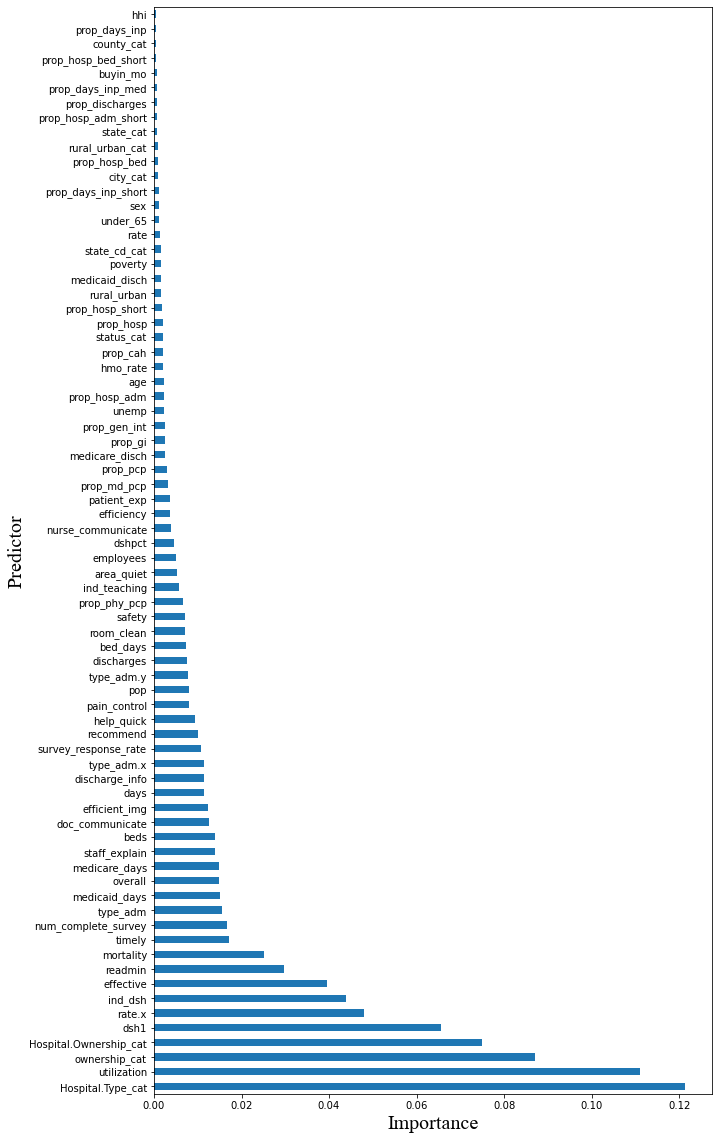

In [74]:
feature_importances_rf_3 = gridsearch_rf_3.best_estimator_.named_steps["classifier"].feature_importances_
feat_importances = pd.Series(feature_importances_rf_3, index=hosp_hcris_.columns)
plt.rcParams['figure.figsize'] = [10,20]
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}
plt.xlabel('Importance', font)
plt.ylabel('Predictor', font)
feat_importances.nlargest(74).plot(kind='barh')
plt.savefig(r'C:/Users/owofangwei/Desktop/project/py/plots/feature_importance_rf_svm.png', bbox_inches = 'tight')

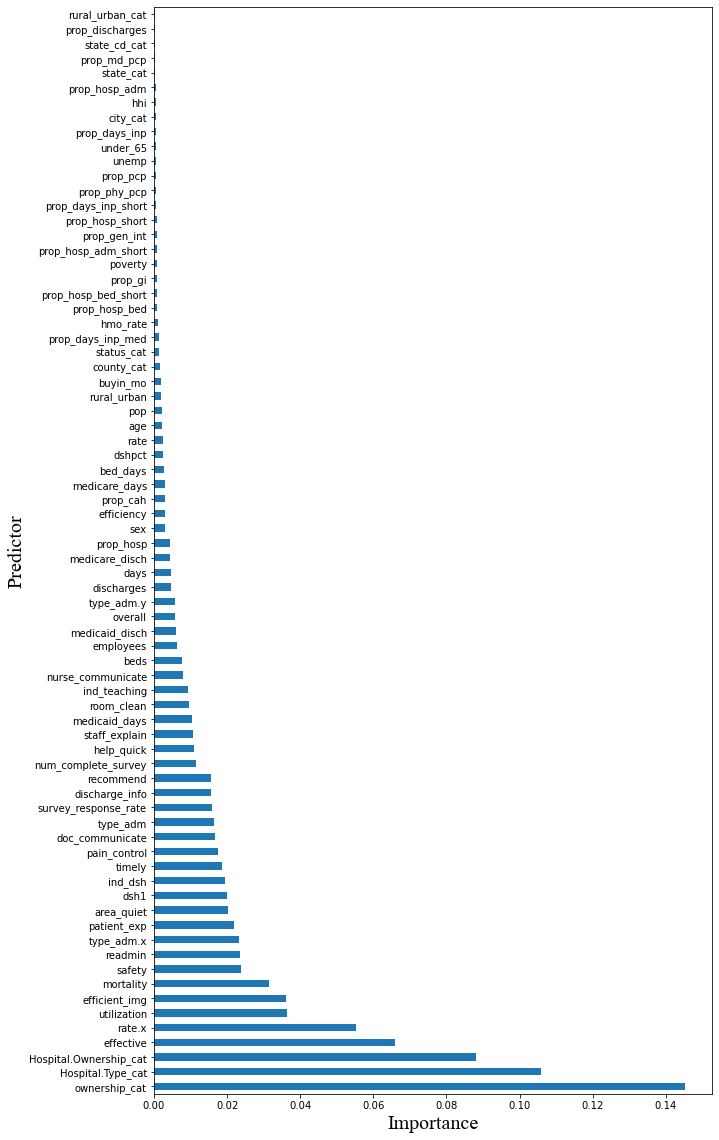

In [75]:
feature_importances_rf_4 = gridsearch_rf_4.best_estimator_.named_steps["classifier"].feature_importances_
feat_importances = pd.Series(feature_importances_rf_4, index=hosp_hcris_.columns)
plt.rcParams['figure.figsize'] = [10,20]
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size' : 20,
}
plt.xlabel('Importance', font)
plt.ylabel('Predictor', font)
feat_importances.nlargest(74).plot(kind='barh')
plt.savefig(r'C:/Users/owofangwei/Desktop/project/py/plots/feature_importance_rf_adasyn.png', bbox_inches = 'tight')